In [20]:
print("Hello World")

Hello World


In [21]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["LANGSMITH_TRACING_V2"] = "true"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

In [22]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

print(db.dialect)
print(db.get_usable_table_names())

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


# Chains

In [23]:
from typing import TypedDict

class State(TypedDict):
    question: str
    query:str
    result:str
    answer:str

In [24]:
from langchain.chat_models import init_chat_model

os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

llm = init_chat_model("gemini-2.0-flash-exp", model_provider="google_genai")

In [25]:
from langchain.prompts import ChatPromptTemplate

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = """ Question: {input}
"""

query_prompt_template = ChatPromptTemplate(
    [
        ("system", system_message),
        ("user", user_prompt)
    ]
)


for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

 Question: {input}



In [26]:
from typing import TypedDict
from typing_extensions import Annotated

class QueryOutput(TypedDict):
    """
    Generated SQL Query
    """
    query: Annotated[str, ..., "Syntactically valid SQL query"]


def write_query(state: State):
    """
    Generate SQL Query to fetch information.
    """
    prompt = query_prompt_template.invoke(
        {
            "input": state["question"],
            "dialect": db.dialect,
            "table_info": db.get_table_info(),
            "top_k": 10
        }
    )

    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [27]:
write_query({"question": "How many employees are there?"})

{'query': 'SELECT count(*) FROM Employee'}

In [28]:
from langchain_community.tools import QuerySQLDatabaseTool


def execute_query(state: State):
    """
    Execute SQL Query.
    """
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}


In [29]:
execute_query({"query": "select count(EmployeeId) as EmployeeCount from Employee"})

{'result': '[(8,)]'}

In [30]:
def generate_answer(state: State):
    """Answer question using retrieved information as context. """
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [31]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)

graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

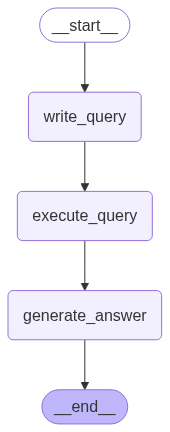

{'question': 'What is the name of the artist with the most tracks?',
 'query': 'SELECT T1.Name FROM Artist AS T1 INNER JOIN Album AS T2 ON T1.ArtistId = T2.ArtistId INNER JOIN Track AS T3 ON T2.AlbumId = T3.AlbumId GROUP BY T1.ArtistId ORDER BY count(*) DESC LIMIT 1',
 'result': "[('Iron Maiden',)]",
 'answer': 'Answer: The artist with the most tracks is Iron Maiden.'}

In [32]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question": "What is the name of the artist with the most tracks?"})

In [33]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT count(*) FROM Employee'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}


In [34]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

config = {"configurable": {"thread_id": "1"}}


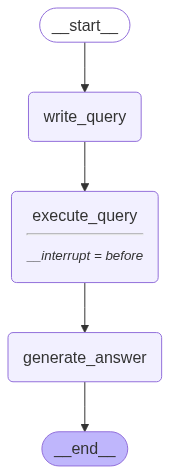

In [35]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
for step in graph.stream(
    {"question": "How many employees are there?"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")

{'write_query': {'query': 'SELECT count(*) FROM Employee'}}
{'__interrupt__': ()}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}


# Agents

In [39]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x11895ac10>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x11895ac10>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x11895ac10>),
 QuerySQLCheckerTool(description='Use this tool to double check if your 

In [ ]:
system_message = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect="SQLite",
    top_k=5,
)

In [40]:
from langgraph.prebuilt import create_react_agent
agent_executor = create_react_agent(llm, tools, prompt=system_message)

In [41]:
question = "Which country's customers spent the most?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which country's customers spent the most?
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (c08b62cf-5d05-41e0-a87f-b4b6d622333a)
 Call ID: c08b62cf-5d05-41e0-a87f-b4b6d622333a
  Args:
    query: SELECT billingcountry, SUM(total) AS total_spent FROM invoice GROUP BY billingcountry ORDER BY total_spent DESC LIMIT 1
================================= Tool Message =================================
Name: sql_db_query

[('USA', 523.06)]
================================== Ai Message ==================================

The customers from USA spent the most.


In [42]:
question = "Describe the playlisttrack table"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Describe the playlisttrack table
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (0217a929-556e-40ce-b9d7-161ce1345a4d)
 Call ID: 0217a929-556e-40ce-b9d7-161ce1345a4d
  Args:
    table_names: playlisttrack
================================= Tool Message =================================
Name: sql_db_schema

Error: table_names {'playlisttrack'} not found in database
================================== Ai Message ==================================

Could you list the tables in the database?
Tool Calls:
  sql_db_list_tables (c9a6636c-673b-46b1-863f-9e6fcd9c554d)
 Call ID: c9a6636c-673b-46b1-863f-9e6fcd9c554d
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
=========================

In [43]:
import ast
import re


def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
albums[:5]

['Facelift',
 'Acústico',
 'Blizzard of Ozz',
 "Mendelssohn: A Midsummer Night's Dream",
 'Szymanowski: Piano Works, Vol.']

In [46]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [47]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [51]:
from langchain.agents.agent_toolkits import create_retriever_tool

_ = vector_store.add_texts(artists + albums)

retriever = vector_store.as_retriever(search_kwargs={"k": 5})

description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)


retriever_tool = create_retriever_tool(
    retriever, 
    name = "search_proper_nouns",
    description=description,
    )

In [52]:
print(retriever_tool.invoke("Alice Chains"))

Alice In Chains

Whitesnake

Pearl Jam

Pearl Jam

Alanis Morissette


In [53]:
# Add to system message
suffix = (
    "If you need to filter on a proper noun like a Name, you must ALWAYS first look up "
    "the filter value using the 'search_proper_nouns' tool! Do not try to "
    "guess at the proper name - use this function to find similar ones."
)

system = f"{system_message}\n\n{suffix}"

tools.append(retriever_tool)
agent = create_react_agent(llm, tools, prompt=system)

In [54]:
question = "How many albums does alis in chain have?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How many albums does alis in chain have?
================================== Ai Message ==================================
Tool Calls:
  search_proper_nouns (0a88daf5-04c5-4748-868c-9aef080a8eed)
 Call ID: 0a88daf5-04c5-4748-868c-9aef080a8eed
  Args:
    query: alis in chain
================================= Tool Message =================================
Name: search_proper_nouns

Alice In Chains

In Step

IV

Transmission

Coda
================================== Ai Message ==================================
Tool Calls:
  sql_db_query (22d1eca9-7521-45ae-86d0-e7a5976b910a)
 Call ID: 22d1eca9-7521-45ae-86d0-e7a5976b910a
  Args:
    query: SELECT count(*) FROM album WHERE artist = 'Alice In Chains'
================================= Tool Message =================================
Name: sql_db_query

Error: (sqlite3.OperationalError) no such column: artist
[SQL: SELECT count(*) FROM album WHERE artist = 'Alice 